### Подключение библиотек и скриптов

In [4]:
# Основные библиотеки
import numpy as np 
import pandas as pd 
import pickle 

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Статистика
from scipy.stats import shapiro
from scipy.stats import chi2_contingency

# 3. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

# 4. Модели
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import catboost as catb
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, \
                             accuracy_score, classification_report, plot_confusion_matrix, \
                             plot_precision_recall_curve, precision_recall_curve, recall_score,
                             plot_roc_curve, f1_score)

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [1899]:
def evaluate_preds(model, X_train, X_valid, y_train, y_valid):
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    print("TRAIN\n", round(f1_score(y_train, y_train_pred), 3))
    print("TEST\n", round(f1_score(y_valid, y_valid_pred), 3))
    get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

In [1900]:
def get_classification_report(y_train_true, y_train_pred, y_valid_true, y_valid_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('VALID\n\n' + classification_report(y_valid_true, y_valid_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_valid_true, y_valid_pred))

In [2]:
TRAIN_DATASET_PATH = '/Users/admin/Desktop/GeekBrains/Библиотеки_Python/Продолжение_классификация/course_project/course_project_train.csv'
TEST_DATASET_PATH = '/Users/admin/Desktop/GeekBrains/Библиотеки_Python/Продолжение_классификация/course_project/course_project_test.csv'
SAMPLE_SUBMIT_PATH = '/Users/admin/Desktop/GeekBrains/Библиотеки_Python/Продолжение_классификация/course_project/sample_submission.csv'

## Первичный анализ данных

In [5]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [1903]:
test_df = pd.read_csv(TEST_DATASET_PATH, sep=',')
test_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [1904]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 7500
Строк в тесте 2500


### Data fields
- Home Ownership - домовладение
- Annual Income - годовой доход
- Years in current job - количество лет на текущем месте работы
- Tax Liens - налоговые обременения
- Number of Open Accounts - количество открытых счетов
- Years of Credit History - количество лет кредитной истории
- Maximum Open Credit - наибольший открытый кредит (максимальная сумма, которая когда-либо была доступна клиенту)
- Number of Credit Problems - количество проблем с кредитом
- Months since last delinquent - количество месяцев с последней просрочки платежа
- Bankruptcies - банкротства
- Purpose - цель кредита
- Term - срок кредита
- Current Loan Amount - текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)
- Current Credit Balance - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)
- Monthly Debt - ежемесячный долг
- Credit Score - баллы кредитного рейтинга
- Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [1905]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [1906]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

Признаки с пропусками в train и test cовпадают. Что может значить такое совпадение - возможно, что эти пропуски не случайны, и есть какая-то закономерность в их наличии.

In [1907]:
train_df.isnull().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [1908]:
test_df.isnull().sum()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

In [1909]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


В результате анализа данных таблицы сделала следующие выводы: 
- предположительно есть выбросы в признаках Maximum Open Credit, Months since last deliquent, Current Loan Amount, Monthly Debt, Credit Score.

## EDA  <a class='anchor' id='eda'>
Делаем EDA для:
- Исправления выбросов
- Заполнения NaN
- Идей для генерации новых фич

### Распределение целевой переменной

<AxesSubplot:xlabel='Credit Default', ylabel='count'>

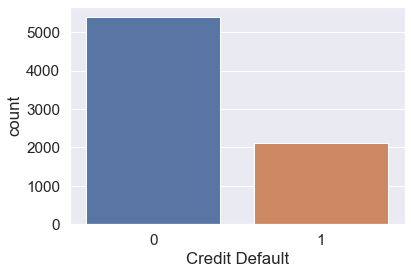

In [1910]:
sns.countplot(x='Credit Default', data=train_df)

In [1911]:
train_df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

### Обзор категориальных признаков

In [1912]:
cat_colnames = train_df.select_dtypes(include='object').columns.to_list()
cat_colnames

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [1913]:
train_df['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

In [1914]:
train_df['Years in current job'].value_counts().sort_index()

1 year        504
10+ years    2332
2 years       705
3 years       620
4 years       469
5 years       516
6 years       426
7 years       396
8 years       339
9 years       259
< 1 year      563
Name: Years in current job, dtype: int64

In [1915]:
train_df['Years in current job'].mode()

0    10+ years
dtype: object

In [1916]:
train_df['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [1917]:
train_df['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

In [1918]:
train_df['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64

### Матрица корреляций

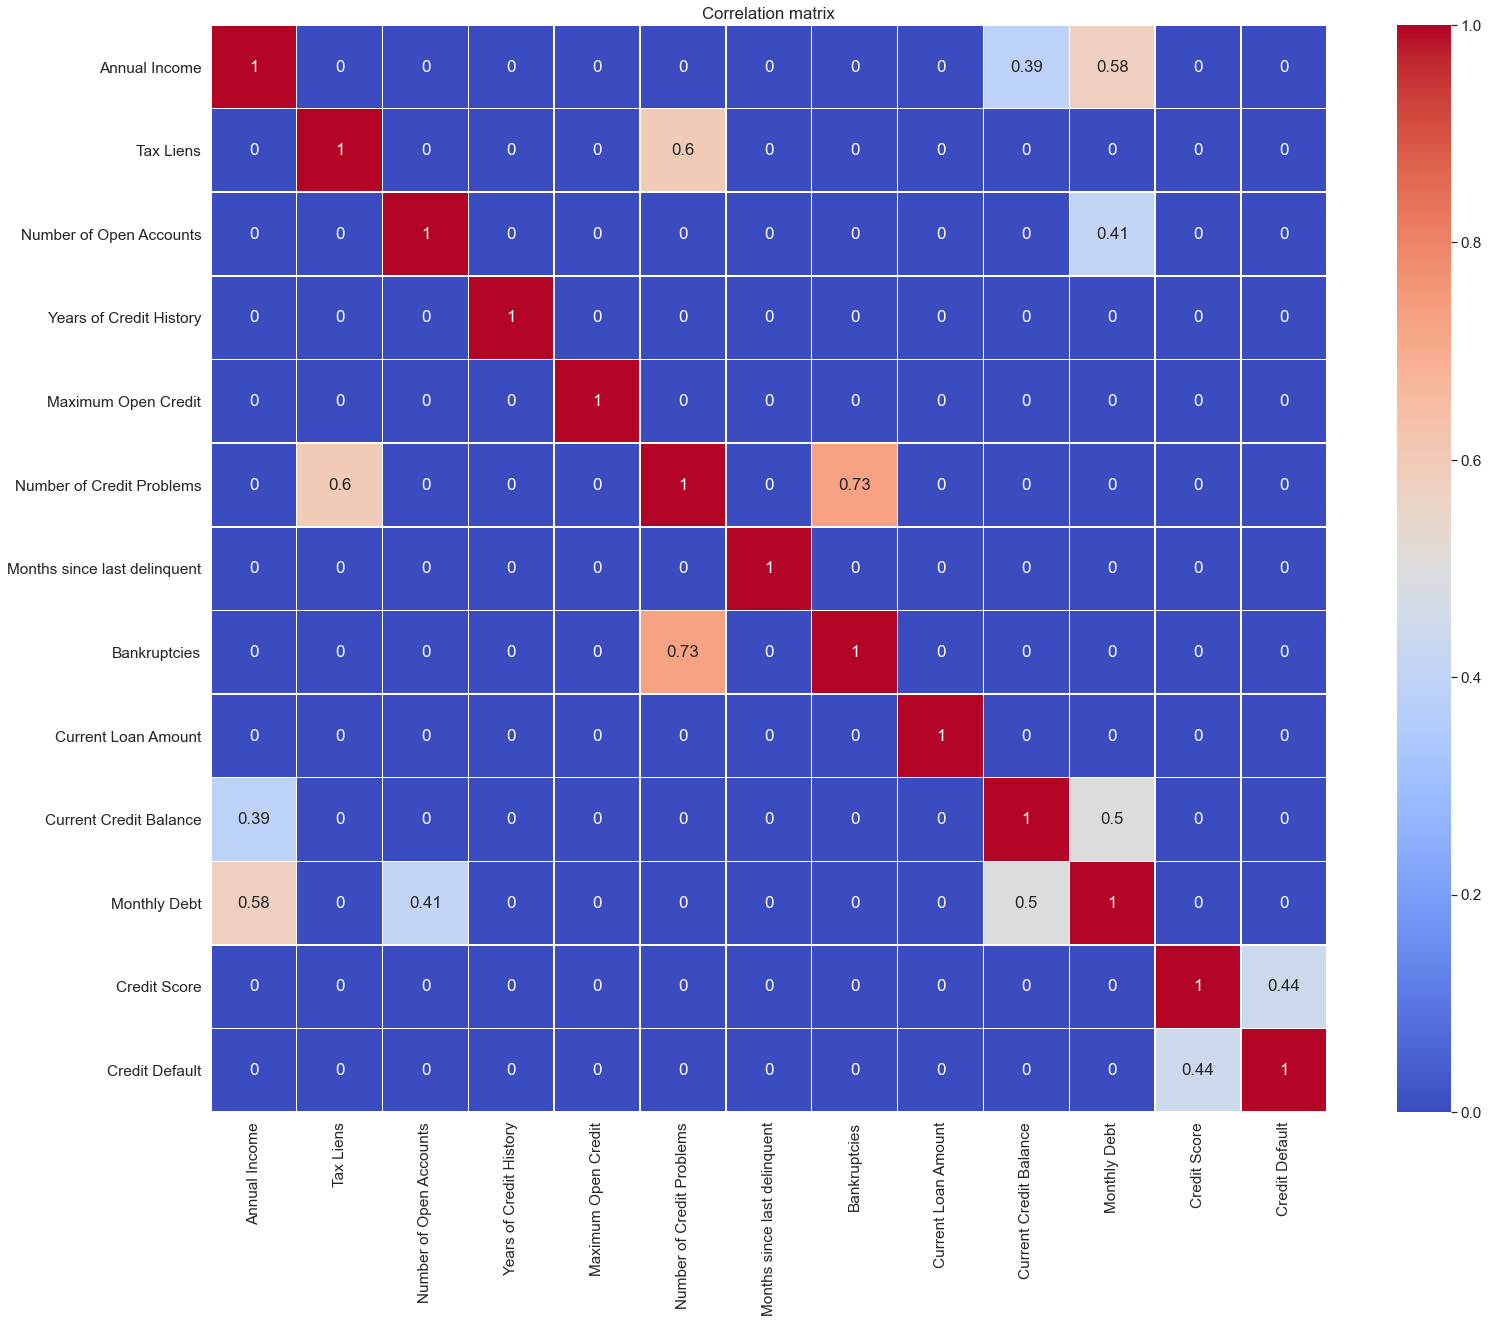

In [1919]:
plt.figure(figsize=(25, 20))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

По матрице корреляций видим уверенную корреляцию Annual Income (годовой доход) с Monthly Debt(Ежемесячный долг) и менее слабую корреляцию с Current Credit Balance (текущий кредитный баланс - сумма, которую может тратить клиент с кредитного счета). Также есть корреляция с признаком Credit Score(+- 0.5 - уверенная корреляция).
Можно отметить очень сильную корреляцию признака 'Bankruptcies'(Банкротство) и 'Number of credit problems'.
Есть корреляции признаков Credit Default и Credit Score, Monthly Debt и Number of Open Accounts, Monthly Debt и Current Credit Balance.

In [1920]:
train_df.loc[train_df['Annual Income'].isnull() & train_df['Credit Score'].isnull()]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1
10,Home Mortgage,NaN,< 1 year,0.0,7.0,11.5,256322.0,0.0,NaN,0.0,debt consolidation,Short Term,220858.0,187492.0,14592.0,NaN,0
16,Rent,NaN,7 years,0.0,6.0,17.8,899492.0,0.0,NaN,0.0,debt consolidation,Long Term,313038.0,538346.0,18844.0,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7482,Home Mortgage,NaN,10+ years,0.0,14.0,30.5,645062.0,0.0,45.0,0.0,debt consolidation,Short Term,188430.0,518662.0,23506.0,NaN,0
7492,Home Mortgage,NaN,10+ years,0.0,10.0,13.3,423984.0,0.0,NaN,0.0,debt consolidation,Short Term,332948.0,161481.0,20966.0,NaN,0
7494,Own Home,NaN,< 1 year,0.0,7.0,8.2,301554.0,0.0,NaN,0.0,debt consolidation,Short Term,290400.0,210938.0,5070.0,NaN,0
7498,Home Mortgage,NaN,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0


Когда у признака Annual Income пропущено значение, то и у Credit Score тоже пропущено значение. Предположу, что это может означать, что человек не работает, годового дохода нет. Соответственно, показатель Credit Score рассчитать невозможно.

## Анализ признаков и обработка выбросов.

#### Количественные признаки

In [1921]:
df_num_features = train_df.select_dtypes(include=['float64', 'int64'])
df_num_features

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,482087.0,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,99999999.0,47386.0,7914.0,749.0,0
1,1025487.0,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,264968.0,394972.0,18373.0,737.0,1
2,751412.0,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,99999999.0,308389.0,13651.0,742.0,0
3,805068.0,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,121396.0,95855.0,11338.0,694.0,0
4,776264.0,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,125840.0,93309.0,7180.0,719.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,402192.0,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,129360.0,73492.0,1900.0,697.0,0
7496,1533984.0,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,444048.0,456399.0,12783.0,7410.0,1
7497,1878910.0,0.0,12.0,32.1,1778920.0,0.0,NaN,0.0,99999999.0,477812.0,12479.0,748.0,0
7498,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,615274.0,476064.0,37118.0,NaN,0


Удалим столбец с целевой переменной и посмотрим на распределение каждого признака на гистограммах:

In [1922]:
df_num_features.drop(['Credit Default'], axis=1, inplace=True)

array([[<AxesSubplot:title={'center':'Annual Income'}>,
        <AxesSubplot:title={'center':'Tax Liens'}>,
        <AxesSubplot:title={'center':'Number of Open Accounts'}>],
       [<AxesSubplot:title={'center':'Years of Credit History'}>,
        <AxesSubplot:title={'center':'Maximum Open Credit'}>,
        <AxesSubplot:title={'center':'Number of Credit Problems'}>],
       [<AxesSubplot:title={'center':'Months since last delinquent'}>,
        <AxesSubplot:title={'center':'Bankruptcies'}>,
        <AxesSubplot:title={'center':'Current Loan Amount'}>],
       [<AxesSubplot:title={'center':'Current Credit Balance'}>,
        <AxesSubplot:title={'center':'Monthly Debt'}>,
        <AxesSubplot:title={'center':'Credit Score'}>]], dtype=object)

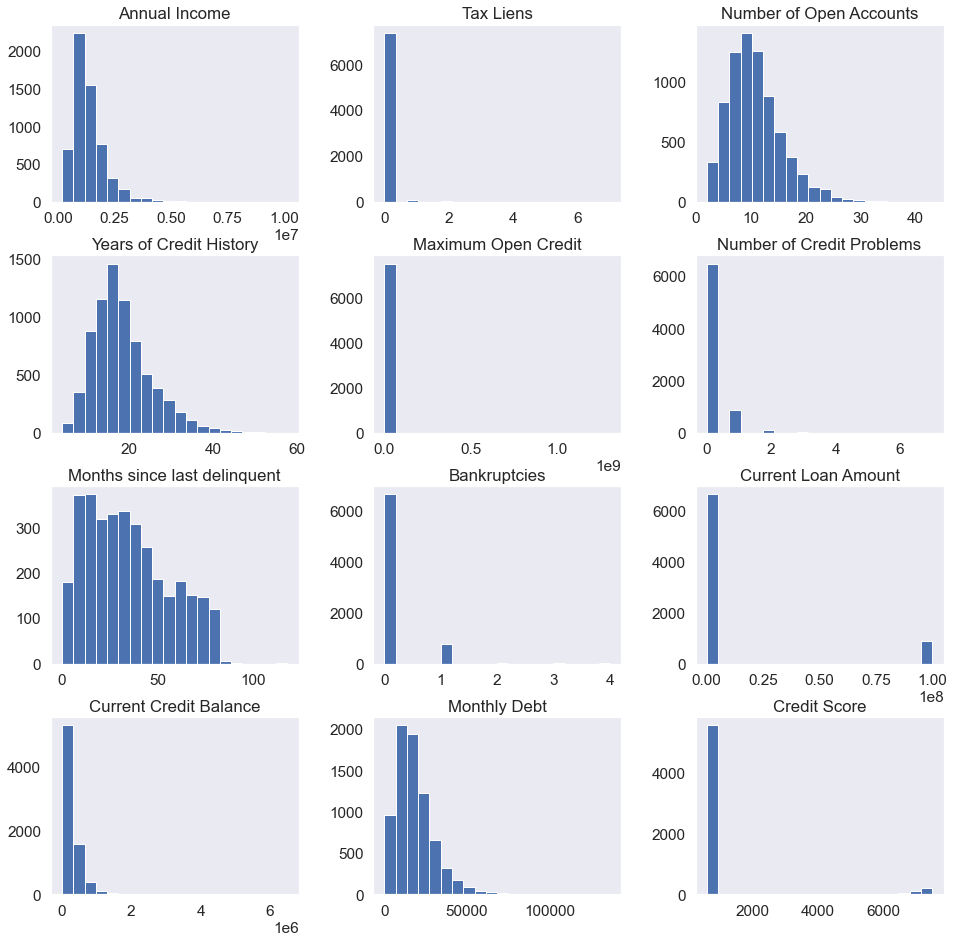

In [1923]:
df_num_features.hist(figsize=(16, 16), bins=20, grid=False)

На гистограммах видно, что выбросы присутствуют в признаках Maximum Open Credit, Months since last deliquent, Current Loan Amount, Monthly Debt, Credit Score.

#### Current Loan Amount

In [1924]:
train_df['Current Loan Amount'].value_counts()

99999999.0    870
218064.0        6
89298.0         6
216106.0        5
265826.0        5
             ... 
104324.0        1
201080.0        1
427812.0        1
665544.0        1
191136.0        1
Name: Current Loan Amount, Length: 5386, dtype: int64

Есть 870 значений, установленных на максимум. Отметим эти столбцы через новый признак Current Loan Amount Outlier:

In [1925]:
train_df['Current Loan Amount Outlier'] = 0
train_df.loc[train_df['Current Loan Amount'] == 99999999.0, 'Current Loan Amount Outlier'] = 1


In [1926]:
train_df.loc[(train_df['Current Loan Amount'] == 99999999.0) & train_df['Credit Default'] == 1]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Current Loan Amount Outlier


Как видим, этим максимумом отмечены добросовестные плательщики кредита, значения 'Credit Score' равного 1 среди них нет.

In [1927]:
train_df['Current Loan Amount'].median()

309573.0

In [1929]:
train_df[train_df['Current Loan Amount'] == 99999999.0]['Current Loan Amount'].count()

870

Оставим эти значения без обработки, будет полезно при построении бустинг-модели.

#### Maximum Open Credit

In [2009]:
train_df['Maximum Open Credit'].max()

1304726170.0

Введем переменную max_credit - показатель равный .95 квантилей, чтобы обработать выбросы, и все, что больше, заменим на медиану.

In [6]:
max_credit = train_df['Maximum Open Credit'].quantile(.95)
max_credit

1706333.1999999997

In [2012]:
train_df['Maximum Open Credit'].median()

478159.0

In [7]:
train_df[train_df['Maximum Open Credit'] > max_credit]['Maximum Open Credit'].value_counts()

1887710.0    2
1713074.0    2
2644444.0    2
2075128.0    1
5590750.0    1
            ..
1757558.0    1
1789568.0    1
2260918.0    1
2002286.0    1
2178836.0    1
Name: Maximum Open Credit, Length: 372, dtype: int64

In [1935]:
train_df['Maximum Open Credit Outlier'] = 0
train_df.loc[train_df['Maximum Open Credit'] > max_credit, 'Maximum Open Credit Outlier'] = 1
train_df.loc[train_df['Maximum Open Credit'] > max_credit, 'Maximum Open Credit'] = train_df['Maximum Open Credit'].median()

In [1936]:
train_df[train_df['Maximum Open Credit Outlier'] == 1]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Current Loan Amount Outlier,Maximum Open Credit Outlier
44,Have Mortgage,1334256.0,10+ years,0.0,17.0,15.4,478159.0,1.0,35.0,0.0,take a trip,Short Term,33110.0,656450.0,34357.0,729.0,0,0,1
617,Home Mortgage,NaN,3 years,0.0,13.0,27.5,478159.0,0.0,NaN,0.0,debt consolidation,Short Term,529892.0,1126814.0,5492.0,NaN,0,0,1
2617,Home Mortgage,3217802.0,10+ years,0.0,12.0,35.5,478159.0,0.0,NaN,0.0,other,Short Term,50116.0,1834450.0,20272.0,750.0,0,0,1


#### Months since last delinquent

In [1937]:
train_df['Months since last delinquent'].describe()

count    3419.000000
mean       34.692600
std        21.688806
min         0.000000
25%        16.000000
50%        32.000000
75%        50.000000
max       118.000000
Name: Months since last delinquent, dtype: float64

Видим, что пропущено более 50% значений, это может означать, что просрочки платежа нет, поэтому заменим пропуски нулями в последующем.

#### Credit Score

In [1938]:
train_df['Credit Score'].describe()

count    5943.000000
mean     1151.087498
std      1604.451418
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64

In [9]:
train_df.loc[train_df['Credit Score'] > 850, ['Credit Score']].count()

Credit Score    400
dtype: int64

In [1940]:
train_df['Credit Score'].median()

731.0

Согласно системе кредитного скоринга FICO score, показатель принимает значения от 300 до 850 и 0. Соответственно, все показатели, выше 850 - явные выбросы. Пометим их через новый признак Credit Score Outlier, а выбросы обработаем следующим образом: разделим значения более 1000 на 10.

In [10]:
train_df['Credit Score Outlier'] = 0
train_df.loc[train_df['Credit Score'] > 850, 'Credit Score Outlier'] = 1
train_df.loc[train_df['Credit Score'] > 850, 'Credit Score'] = train_df.loc[train_df['Credit Score'] > 850, 'Credit Score']/10

#### Monthly Debt

In [1942]:
train_df['Monthly Debt'].quantile(.95)

40546.2

In [1943]:
train_df['Monthly Debt'].describe()

count      7500.000000
mean      18314.454133
std       11926.764673
min           0.000000
25%       10067.500000
50%       16076.500000
75%       23818.000000
max      136679.000000
Name: Monthly Debt, dtype: float64

In [1944]:
train_df['Monthly Debt'].median()

16076.5

Видим явные выбросы в данном показателе. Возможно, это реальные цифры. Но для улучшения качества модели попробуем заменить экстремальные значения на показатель медианы:

In [1945]:
train_df[train_df['Monthly Debt'] > train_df['Monthly Debt'].quantile(.95)]['Monthly Debt'].count()

375

In [1946]:
train_df.loc[train_df['Monthly Debt'] > train_df['Monthly Debt'].quantile(.95), 'Monthly Debt'] = train_df['Monthly Debt'].median()

In [1947]:
train_df['Monthly Debt'].describe()

count     7500.000000
mean     16524.408867
std       8661.900956
min          0.000000
25%      10067.500000
50%      16075.750000
75%      21938.500000
max      40546.000000
Name: Monthly Debt, dtype: float64

## Обработка пропусков

In [1948]:
train_df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
Current Loan Amount Outlier        0
Maximum Open Credit Outlier        0
Credit Score Outlier               0
dtype: int64

#### Annual Income

Когда у признака Annual Income пропущено значение, то и у Credit Score тоже пропущено значение. Предположу, что это может означать, что человек не работает, годового дохода нет. Соответственно, пропуски в показателе Annual Income заменим на 1 (чтобы пометить его таким образом, а также не вызвать ошибку деления на ноль при расчете финансовых показателей).

In [1949]:
train_df['Annual Income'].fillna(1, inplace=True)

In [1950]:
train_df['Annual Income'].isna().sum()

0

#### Credit Score

##### Распределение признака Credit Score (кредитный рейтинг). Изменения целевой переменной при разных значениях кредитного рейтинга. 

Text(0.5, 0, 'Credit Score')

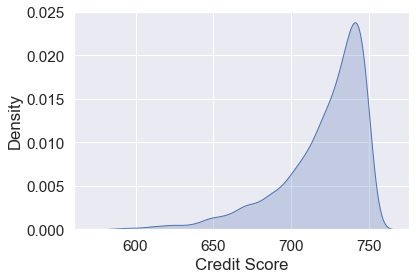

In [1951]:
sns.kdeplot(train_df['Credit Score'], shade=True, legend=False)
plt.xlabel('Credit Score')

<AxesSubplot:xlabel='Credit Score', ylabel='Density'>

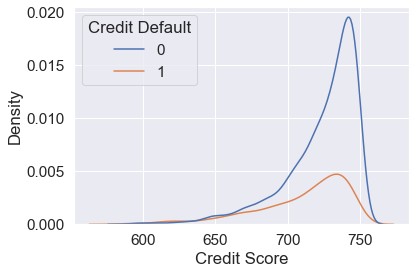

In [1952]:
sns.kdeplot(x='Credit Score', hue='Credit Default', data=train_df)

Вывод - группы, полученные в результате разбиения признака Credit Score по целевой переменной, имеют различные распределения, значит, критерий важен и между Credit Score и целевой переменной существует зависимость.
Предположу, что пропуски в Credit Score можно заменить на 0, так как соответствует пропущенным значениям в признаке Annual Income, а значит рассчитать показатель невозможно. Перед этим создадим новый признак 'Credit Score NaN', чтобы пометить пропущенные данные.

In [1953]:
train_df['Credit Score'].median()

729.0

In [1954]:
train_df['Credit Score NaN'] = 0
train_df.loc[train_df['Credit Score'].isna(), 'Credit Score NaN'] = 1


In [1955]:
train_df['Credit Score'].fillna(0, inplace=True)

In [1956]:
train_df['Credit Score'].isna().sum()

0

#### Years in current job

Пропуски в признаке Years in current job (количество лет на текущем месте работы) могут означать отсутствие данных или то, что клиент банка еще или уже не работает. Пометим пропуски дополнительным признаком и заменим на 0.

In [1957]:
train_df['Years in current job'].value_counts().sort_index()

1 year        504
10+ years    2332
2 years       705
3 years       620
4 years       469
5 years       516
6 years       426
7 years       396
8 years       339
9 years       259
< 1 year      563
Name: Years in current job, dtype: int64

In [1958]:
train_df['Years in current job'].isna().sum()

371

In [1959]:
train_df['Years in current job'].mode()[0]

'10+ years'

In [11]:
train_df['Years in current job NaN'] = 0
train_df.loc[train_df['Years in current job'].isna(), 'Years in current job NaN'] = 1
train_df['Years in current job'].fillna(0, inplace=True)

In [1961]:
train_df['Years in current job'].isna().sum()

0

#### Months since last delinquent

Пропущено более 50% значений. Попробуем оценить важность данного признака в разрезе целевой переменной.

<AxesSubplot:xlabel='Months since last delinquent', ylabel='Density'>

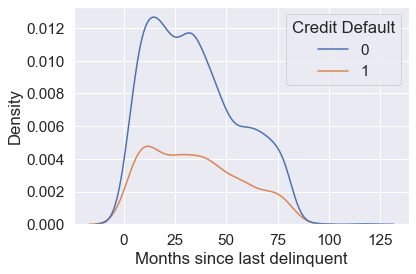

In [1962]:
sns.kdeplot(x='Months since last delinquent', hue='Credit Default', data=train_df)

Судя по графику влияние есть. Пометим отсутствующие значения через новый признак 'Months since last delinquent NaN' и заполним их нулями, предположив, что просрочки нет.

In [1963]:
train_df['Months since last delinquent NaN'] = 0
train_df.loc[train_df['Months since last delinquent'].isna(), 'Months since last delinquent NaN'] = 1

In [1964]:
train_df['Months since last delinquent'].fillna(0, inplace=True)

#### Bankruptcies

In [1965]:
train_df['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

Это категориальный признак.

In [1966]:
train_df['Bankruptcies'].isna().sum()

14

In [1967]:
train_df['Bankruptcies'].mode()[0]

0.0

Пропуски отметим через новый признак 'Bankruptcies NaN' и заменим их на моду.

In [1968]:
train_df['Bankruptcies'].isna().sum()

14

In [1969]:
train_df['Bankruptcies NaN'] = 0
train_df.loc[train_df['Bankruptcies'].isna(), 'Bankruptcies NaN'] = 1
train_df['Bankruptcies'].fillna(train_df['Bankruptcies'].mode()[0], inplace=True)

#### Number of Credit Problems

In [1970]:
train_df['Number of Credit Problems'].value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

Это также категориальный признак.

In [1971]:
train_df.isna().sum()

Home Ownership                      0
Annual Income                       0
Years in current job                0
Tax Liens                           0
Number of Open Accounts             0
Years of Credit History             0
Maximum Open Credit                 0
Number of Credit Problems           0
Months since last delinquent        0
Bankruptcies                        0
Purpose                             0
Term                                0
Current Loan Amount                 0
Current Credit Balance              0
Monthly Debt                        0
Credit Score                        0
Credit Default                      0
Current Loan Amount Outlier         0
Maximum Open Credit Outlier         0
Credit Score Outlier                0
Credit Score NaN                    0
Years in current job NaN            0
Months since last delinquent NaN    0
Bankruptcies NaN                    0
dtype: int64

Пропусков больше нет.

### Построение новых признаков

#### Home Ownership

In [1972]:
train_df['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

Сравним попарно доли целевой переменной в категориях признака Home Ownership (домовладение):

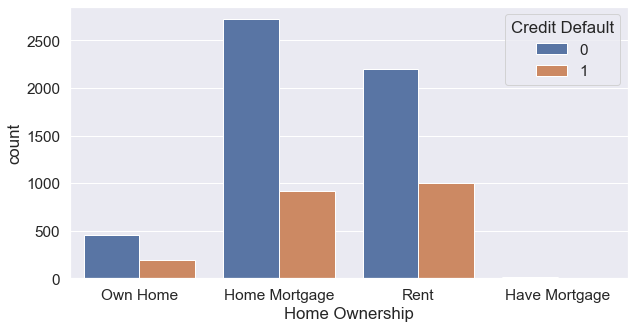

In [1973]:
plt.figure(figsize = (10, 5))
sns.countplot(x='Home Ownership', hue='Credit Default', data=train_df)
plt.legend(title='Credit Default', loc='upper right')

Наблюдение

Из графика видно, что значения Own Home и Rent признака 'Home Ownership' имеют схожие доли в разрезе целевой переменной. Если это действительно так, то можно будет, например, объединить их в одну категорию.

Гипотеза

Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы.

Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы.

Критерий: Хи-квадрат Пирсона

Уровень значимости  𝛼=0.05 

Критическая область: двухсторонняя

Для проверки данной гипотезы необходимо подать наблюдаемые частоты категорий Own Home и Rent признака Home Owvership в выбранный критерий, после чего оценить значение достигаемого уровня значимости p-value и сравнить с его с выбранным порогом альфа. Если p-value получится больше выбранного порога, то гипотезу о согласованности частот можно не отбрасывать.

Сформируем выборку и рассчитаем наблюдаемые частоты

In [1974]:
home_ownership_and_target = train_df.loc[train_df['Home Ownership'].isin(['Own Home', 'Rent']), ['Home Ownership', 'Credit Default']].sample(1000)
home_ownership_and_target['id'] = home_ownership_and_target.index

home_ownership_and_target

,Home Ownership,Credit Default,id
6146,Rent,0,6146
534,Own Home,1,534
6239,Own Home,0,6239
5164,Rent,1,5164
7158,Rent,0,7158
...,...,...,...
4082,Rent,0,4082
1974,Rent,1,1974
3507,Own Home,0,3507
2847,Rent,1,2847


In [1975]:
table = home_ownership_and_target.pivot_table(values='id', index='Home Ownership', columns='Credit Default', aggfunc='count')
table

Credit Default,0,1
Home Ownership,,
Own Home,121,37
Rent,572,270


In [1976]:
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p

0.03056131193798719

In [1977]:
p > 0.05

False

P-value получилось больше выбранного уровня значимости, соответственно у нас нет оснований для отвержения нулевой гипотезы, а это значит, что категории Own Home и Rent одинаково влияют на целевую переменную и их можно объединить в одну категорию.

Проверим нашу гипотезу и на признаке Own Home и Have Mortgage (на графике распределение последнего не видно):

In [1978]:
home_ownership_and_target_1 = train_df.loc[train_df['Home Ownership'].isin(['Own Home', 'Have Mortgage']), ['Home Ownership', 'Credit Default']]
home_ownership_and_target_1['id'] = home_ownership_and_target_1.index

home_ownership_and_target_1

,Home Ownership,Credit Default,id
0,Own Home,0,0
1,Own Home,1,1
3,Own Home,0,3
14,Own Home,0,14
23,Own Home,1,23
...,...,...,...
7473,Own Home,0,7473
7474,Own Home,0,7474
7479,Own Home,0,7479
7490,Own Home,1,7490


In [1979]:
table_1 = home_ownership_and_target_1.pivot_table(values='id', index='Home Ownership', columns='Credit Default', aggfunc='count')
table_1

Credit Default,0,1
Home Ownership,,
Have Mortgage,10,2
Own Home,455,192


In [1980]:
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p

0.03056131193798719

In [1981]:
p > 0.05

False

P-value получилось больше выбранного уровня значимости, соответственно у нас нет оснований для отвержения нулевой гипотезы, а это значит, что категории Own Home и Have Mortgage тоже одинаково влияют на целевую переменную и их можно объединить в одну категорию.

In [1982]:
train_df.loc[train_df['Home Ownership'].isin(['Rent', 'Have Mortgage']), 'Home Ownership'] = 'Own Home'
train_df['Home Ownership'].value_counts()

Own Home         3863
Home Mortgage    3637
Name: Home Ownership, dtype: int64

Теперь можно перевести Home Ownership в бинарный признак: Own Home - 1, Home Mortgage - 0:

In [1983]:
train_df['Home Ownership'] = train_df['Home Ownership'].map({'Own Home': 1, 'Home Mortgage': 0})
train_df.head(3)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Monthly Debt,Credit Score,Credit Default,Current Loan Amount Outlier,Maximum Open Credit Outlier,Credit Score Outlier,Credit Score NaN,Years in current job NaN,Months since last delinquent NaN,Bankruptcies NaN
0,1,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,...,7914.0,749.0,0,1,0,0,0,1,1,0
1,1,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,...,18373.0,737.0,1,0,0,0,0,0,1,0
2,0,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,...,13651.0,742.0,0,1,0,0,0,0,1,0


#### Term

In [1984]:
train_df['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

Сравним доли целевой переменной в категориях признака Term (срок кредита):


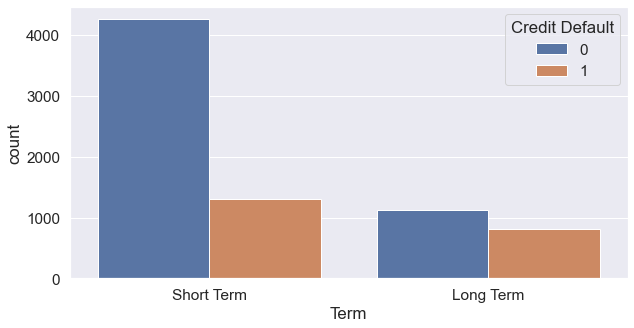

In [1985]:
plt.figure(figsize = (10, 5))
sns.countplot(x='Term', hue='Credit Default', data=train_df)
plt.legend(title='Credit Default', loc='upper right')

Судя по графикам признак Term является сильным, так как очевидно, что категории при разном значении целевой переменной распределены по-разному. Переведем его в бинарный признак на основании Term: 1- Long Term, 0- Short Term:

In [1986]:
train_df['Term'] = train_df['Term'].map({'Long Term': 1, 'Short Term': 0})
train_df.head(3)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Monthly Debt,Credit Score,Credit Default,Current Loan Amount Outlier,Maximum Open Credit Outlier,Credit Score Outlier,Credit Score NaN,Years in current job NaN,Months since last delinquent NaN,Bankruptcies NaN
0,1,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,...,7914.0,749.0,0,1,0,0,0,1,1,0
1,1,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,...,18373.0,737.0,1,0,0,0,0,0,1,0
2,0,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,...,13651.0,742.0,0,1,0,0,0,0,1,0


#### Years in current job - сделаем разбивку на категории: 0, до 3, 4-6, 7-9, 10+ лет

In [12]:
train_df['Years in current job'] = train_df['Years in current job'].map({'< 1 year':0, 
                                                                       '1 year':0, 
                                                                       '2 years':0, 
                                                                       '3 years':0, 
                                                                       '4 years':1, 
                                                                       '5 years':1, 
                                                                       '6 years':1, 
                                                                       '7 years':2,
                                                                       '8 years':2,
                                                                       '9 years':2,
                                                                       '10+ years':3,
                                                                        0 : 4})

In [1988]:
train_df.head(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Monthly Debt,Credit Score,Credit Default,Current Loan Amount Outlier,Maximum Open Credit Outlier,Credit Score Outlier,Credit Score NaN,Years in current job NaN,Months since last delinquent NaN,Bankruptcies NaN
0,1,482087.0,3,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,...,7914.0,749.0,0,1,0,0,0,1,1,0
1,1,1025487.0,3,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,...,18373.0,737.0,1,0,0,0,0,0,1,0
2,0,751412.0,2,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,...,13651.0,742.0,0,1,0,0,0,0,1,0
3,1,805068.0,1,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,...,11338.0,694.0,0,0,0,0,0,0,1,0
4,1,776264.0,2,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,...,7180.0,719.0,0,0,0,0,0,0,1,0


#### Purpose

In [1989]:
train_df['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

Применим Label Encoding для категориального признака 'Purpose'. Для этого категориям присвоим целые числа по следующему принципу:
- 'debt consolidation' - 0, 'other' - 1, 'home improvements' - 2, 'business loan' - 3, 'buy a car' - 4.
- для остальных малочисленных классов (<96 объектов) присвоим число 5.
- далее этот признак будем включать в модель CatBoost, которая умеет работать с категориями.

In [1990]:
train_df['Purpose'] = train_df['Purpose'].map({'debt consolidation':0, 
                                            'other':1, 
                                            'home improvements':2, 
                                            'business loan':3, 
                                            'buy a car':4, 
                                            'medical bills':5, 
                                            'major purchase':5, 
                                            'take a trip':5,
                                            'buy house':5,
                                            'small business':5,
                                            'wedding': 5,
                                            'moving': 5,
                                            'educational expenses': 5,
                                            'vacation': 5,
                                            'renewable energy': 5})
        
        
        

In [1991]:
train_df['Purpose'].value_counts()

0    5944
1     665
2     412
5     254
3     129
4      96
Name: Purpose, dtype: int64

#### Loan Repayment Period, Loan Payment Share, Net Debt

Добавим новые признаки на основе финансовых коэффициентов для оценки кредитоспособности клиента:

- Период выплаты кредита из дохода (Loan Repayment Period) = Размер кредита / Годовой доход
- Доля платежа по кредиту в доходе (Loan Payment Share) = Годовой платеж по кредиту / Годовой доход
- Чистый долг (Net Debt) = Размер кредита - Размер дохода

In [1992]:
 # Loan Repayment Period
train_df['Loan Repayment Period'] = train_df['Current Loan Amount'] / train_df['Annual Income']
        
# Loan Payment Share        
train_df['Loan Payment Share'] = (train_df['Monthly Debt'] * 12) / train_df['Annual Income']
        
# Net Debt
train_df['Net Debt'] = train_df['Current Loan Amount'] - (train_df['Annual Income'] / 12)

#### Credit Score- Сделаем разбивку рейтинга на категории:

    - Excellent: 800 to 850
    - Very Good: 740 to 799
    - Good: 670 to 739
    - Fair: 580 to 669
    - Poor: 300 to 579

In [1993]:
def credit_score_to_cat(X):
    bins = [300, 579, 669, 739, 799, 850]
    X['Credit Score Cat'] = pd.cut(X['Credit Score'], bins=bins, labels=False)
    
    X['Credit Score Cat'].fillna(-1, inplace=True)
    return X

In [1994]:
train_df = credit_score_to_cat(train_df)
train_df.head(3)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Maximum Open Credit Outlier,Credit Score Outlier,Credit Score NaN,Years in current job NaN,Months since last delinquent NaN,Bankruptcies NaN,Loan Repayment Period,Loan Payment Share,Net Debt,Credit Score Cat
0,1,482087.0,3,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,...,0,0,0,1,1,0,207.431437,0.196993,9.995983e+07,3.0
1,1,1025487.0,3,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0.258383,0.214996,1.795108e+05,2.0
2,0,751412.0,2,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,...,0,0,0,0,1,0,133.082781,0.218006,9.993738e+07,3.0


In [1995]:
train_df['Credit Score'].max()

751.0

# Классы обработки данных

### Подготовка исходных данных, обработка выбросов и пропусков

In [379]:
class DataPreprocessing:
    
    def __init__(self):
        self.medians=None
        self.modes = None
        self.max_score = 850
        
        
    def fit(self, X):
        """Сохранение статистик""" 
        X = X.copy()
        # Расчет медиан и мод
        self.medians = X.median()
        self.modes = X.mode().loc[0]
        self.max_credit = X['Maximum Open Credit'].quantile(.95)
                
    def transform(self, X):
        """Трансформация данных"""

        # Credit score
        X['Credit Score Outlier'] = 0
        X['Credit Score NaN'] = 0
        X.loc[X['Credit Score'] > self.max_score, 'Credit Score Outlier'] = 1
        X.loc[X['Credit Score'].isna(), 'Credit Score NaN'] = 1
        
        
        X.loc[X['Credit Score'] > self.max_score, 'Credit Score'] = \
                                X.loc[X['Credit Score'] > self.max_score, 'Credit Score'] / 10
        X['Credit Score'].fillna(0, inplace = True)
            
        # Current Loan Amount
        X['Current Loan Amount Outlier'] = 0
        X.loc[X['Current Loan Amount'] == 99999999.0, 'Current Loan Amount Outlier'] = 1
        
        # Maximum Open Credit
        X['Maximum Open Credit Outlier'] = 0
        X.loc[X['Maximum Open Credit'] > max_credit, 'Maximum Open Credit Outlier'] = 1
        X.loc[X['Maximum Open Credit'] > max_credit, 'Maximum Open Credit'] = X['Maximum Open Credit'].median()
               
        # Annual Income
        X['Annual Income'].fillna(1, inplace = True)
        
        #Monthly Debt
        X.loc[X['Monthly Debt'] > X['Monthly Debt'].quantile(.95), 'Monthly Debt'] = self.medians['Monthly Debt']
        
        # Years in current job
        X['Years in current job NaN'] = 0
        X.loc[X['Years in current job'].isna(), 'Years in current job NaN'] = 1
        X['Years in current job'].fillna(0, inplace = True)
        
        # Months since last delinquent
        
        X['Months since last delinquent NaN'] = 0
        X.loc[X['Months since last delinquent'].isna(), 'Months since last delinquent NaN'] = 1
        X['Months since last delinquent'].fillna(0, inplace=True)
        
        # Bankruptcies
        X['Bankruptcies NaN'] = 0
        X.loc[X['Bankruptcies'].isna(), 'Bankruptcies NaN'] = 1
        X['Bankruptcies'].fillna(self.modes['Bankruptcies'], inplace = True)
        
        X.fillna(self.medians, inplace=True)
        
        return X

### Генерация новых признаков

In [2043]:
class FeatureGenerator():
    """Генерация новых фич"""
    
      
    def fit(self, X, y=None):
        X = X.copy()
                
    def transform(self, X):
        
        #Home Ownership
        X.loc[X['Home Ownership'].isin(['Rent', 'Have Mortgage']), 'Home Ownership'] = 'Own Home'
        X['Home Ownership'] = X['Home Ownership'].map({'Own Home': 1, 'Home Mortgage': 0})
        
        # Term
        X['Term'] = X['Term'].map({'Long Term': 1, 'Short Term': 0})
                
        # Years in current job
        X['Years in current job'] = X['Years in current job'].map({'< 1 year':0, 
                                                                       '1 year':0, 
                                                                       '2 years':0, 
                                                                       '3 years':0, 
                                                                       '4 years':1, 
                                                                       '5 years':1, 
                                                                       '6 years':1, 
                                                                       '7 years':2,
                                                                       '8 years':2,
                                                                       '9 years':2,
                                                                       '10+ years':3,
                                                                  0:4})
        
        # Purpose
        
        X['Purpose'] = X['Purpose'].map({'debt consolidation':0, 
                                            'other':1, 
                                            'home improvements':2, 
                                            'business loan':3, 
                                            'buy a car':4, 
                                            'medical bills':5, 
                                            'major purchase':5, 
                                            'take a trip':5,
                                            'buy house':5,
                                            'small business':5,
                                            'wedding': 5,
                                            'moving': 5,
                                            'educational expenses': 5,
                                            'vacation': 5,
                                            'renewable energy': 5})
        
        
        
         # Loan Repayment Period 
            
        X['Loan Repayment Period'] = X['Current Loan Amount'] / X['Annual Income']
 
        # Loan Payment Share
        
        X['Loan Payment Share'] = (X['Monthly Debt'] * 12) / X['Annual Income']
        
        # Net Debt
        
        X['Net Debt'] = X['Current Loan Amount'] - (X['Annual Income'] / 12)
        
        # Credit Score
        X = self.credit_score_to_cat(X)
        
        return X
    
    def credit_score_to_cat(self, X):
        bins = [300, 579, 669, 739, 799, 850]
        X['Credit Score Cat'] = pd.cut(X['Credit Score'], bins=bins, labels=False)

        X['Credit Score Cat'].fillna(-1, inplace=True)
        X['Credit Score Cat'] = X['Credit Score Cat'].astype(np.int)
        
        return X

## Отбор признаков

In [2028]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [380]:
num_feature_names = [
 'Annual Income',
'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
'Credit Score', 'Loan Repayment Period', 'Loan Payment Share', 'Net Debt']

In [381]:
cat_feature_names = [#'Tax Liens', 
    'Years in current job', 'Number of Credit Problems','Home Ownership', 
                     #'Bankruptcies', 
                     'Purpose', 'Credit Score Cat']

In [382]:
new_feature_names = ['Current Loan Amount Outlier',
 #'Maximum Open Credit Outlier',
 'Credit Score Outlier',
#'Credit Score NaN',
 'Years in current job NaN',
 #'Months since last delinquent NaN',
 #'Bankruptcies NaN'
]

target_name = 'Credit Default'

## Разбиение на train и test

In [383]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)
X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [384]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [385]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X = preprocessor.transform(X)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape, X.shape

((5025, 23), (2475, 23), (2500, 23), (7500, 23))

In [386]:
features_gen = FeatureGenerator()
features_gen.fit(X_train, y_train)

X = features_gen.transform(X)
X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape, X.shape

((5025, 27), (2475, 27), (2500, 27), (7500, 27))

In [387]:
selected_feature_names = num_feature_names + new_feature_names + cat_feature_names
len(selected_feature_names)

20

In [388]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5025 entries, 3151 to 7270
Data columns (total 27 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Home Ownership                    5025 non-null   int64  
 1   Annual Income                     5025 non-null   float64
 2   Years in current job              5025 non-null   int64  
 3   Tax Liens                         5025 non-null   float64
 4   Number of Open Accounts           5025 non-null   float64
 5   Years of Credit History           5025 non-null   float64
 6   Maximum Open Credit               5025 non-null   float64
 7   Number of Credit Problems         5025 non-null   float64
 8   Months since last delinquent      5025 non-null   float64
 9   Bankruptcies                      5025 non-null   float64
 10  Purpose                           5025 non-null   int64  
 11  Term                              5025 non-null   int64  
 12  Cur

In [389]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

Переведем категориальные признаки к типу int:

In [390]:
def float_to_int(X):
    for col in cat_feature_names:
        if X[col].dtypes == 'float64':
            X[col] = X[col].astype('int')        
    return X

In [391]:
X_train = float_to_int(X_train)
X_valid = float_to_int(X_valid)
X = float_to_int(X)
test_df = float_to_int(test_df)

In [392]:
X_train = X_train[selected_feature_names]
X_valid = X_valid[selected_feature_names]
X = X[selected_feature_names]
test_df = test_df[selected_feature_names]

In [393]:
test_df[cat_feature_names].dtypes

Years in current job         int64
Number of Credit Problems    int64
Home Ownership               int64
Purpose                      int64
Credit Score Cat             int64
dtype: object

## Построение моделей

Построим базовую модель CatBoost:

In [2058]:
model_catb = catb.CatBoostClassifier(silent=True, 
                                     random_state=21, eval_metric='F1')

model_catb.fit(X_train, y_train, plot=True, eval_set=(X_valid, y_valid))

evaluate_preds(model_catb, X_train, X_valid, y_train, y_valid)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN
 0.913
TEST
 0.469
TRAIN

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3631
           1       1.00      0.84      0.91      1394

    accuracy                           0.96      5025
   macro avg       0.97      0.92      0.94      5025
weighted avg       0.96      0.96      0.95      5025

VALID

              precision    recall  f1-score   support

           0       0.78      0.93      0.85      1756
           1       0.68      0.36      0.47       719

    accuracy                           0.76      2475
   macro avg       0.73      0.64      0.66      2475
weighted avg       0.75      0.76      0.74      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1633  123
1                461  258


In [2059]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (14, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()

    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

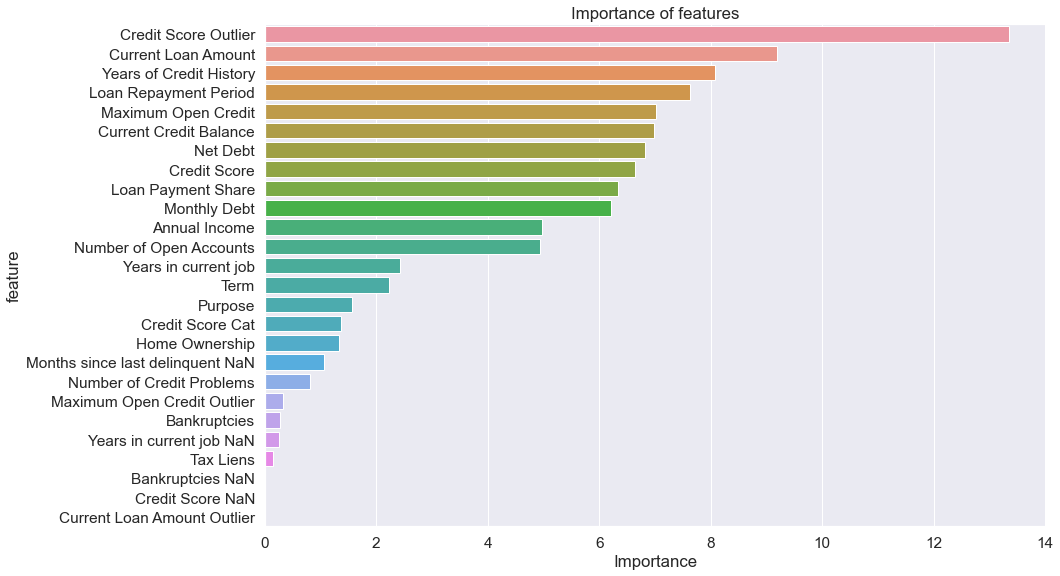

In [2060]:
important_features_top = show_feature_importances(X_train.columns, 
                                                  model_catb.feature_importances_, 
                                                  get_top=15)

Исключим из модели признаки, значения которых ниже 1.

### Улучшение модели CatBoost

In [394]:
cat_features = [i for i, col in enumerate(selected_feature_names) if col in cat_feature_names]
cat_features

[15, 16, 17, 18, 19]

In [395]:
scale = int(y_train[y_train == 0].shape[0] / y_train[y_train == 1].shape[0])
scale

2

In [396]:
X_train[selected_feature_names].iloc[:,cat_features].columns

Index(['Years in current job', 'Number of Credit Problems', 'Home Ownership',
       'Purpose', 'Credit Score Cat'],
      dtype='object')

### Cross Validation

In [2070]:
from catboost import Pool, cv

pool = Pool(data=X,
            label=y,
            cat_features=cat_features)

params = {"iterations": 1000,
          "depth": 4,
          "learning_rate": 0.1,
          "loss_function": "Logloss",
          "custom_loss": 'F1',
          "random_seed": 21,
          "verbose": False}

scores = cv(pool=pool,
            params=params,
            fold_count=3,
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [2071]:
scores.head()

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-F1-mean,test-F1-std,train-F1-mean,train-F1-std
0,0,0.636122,0.002426,0.635780,0.002696,0.358660,0.075378,0.355990,0.063064
1,1,0.604746,0.001854,0.604202,0.001980,0.320483,0.010629,0.319607,0.005697
2,2,0.577000,0.006841,0.576201,0.007442,0.327370,0.020323,0.327429,0.013163
3,3,0.553096,0.004040,0.552355,0.004213,0.319163,0.009825,0.318997,0.006774
4,4,0.539363,0.004593,0.538335,0.004855,0.319285,0.009614,0.318997,0.006774


In [2072]:
best_value = np.max(scores['test-F1-mean'])
best_iter = np.argmax(scores['test-F1-mean'])

print('Best validation F1-score: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    scores['test-F1-std'][best_iter],
    best_iter)
)

Best validation F1-score: 0.4580±0.0113 on step 942


### Выбор лучшей модели и подбор гиперпараметров

#### Подбор гиперпараметров RandomizedSearchCV

In [2073]:
params = {'n_estimators':[50, 100, 300],
          'max_depth':[2, 4, 6]
         }

In [2074]:
cv = KFold(n_splits=5, random_state=21, shuffle=True)

In [2075]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, random_state=21, n_jobs=-1)
rs.fit(X_train, y_train)

CPU times: user 811 ms, sys: 171 ms, total: 982 ms
Wall time: 7.87 s


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x7fa440cda520>,
                   n_jobs=-1,
                   param_distributions={'max_depth': [2, 4, 6],
                                        'n_estimators': [50, 100, 300]},
                   random_state=21, scoring='f1')

In [2076]:
rs.best_params_

{'n_estimators': 50, 'max_depth': 6}

In [2077]:
rs.best_score_

0.4670581416859127

#### Подбор гиперпараметров CatBoost

In [2078]:
model_catb = catb.CatBoostClassifier(n_estimators=50,
                                     custom_loss=['F1'], 
                                     silent=True, 
                                     random_state=21)
grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth':[2, 4, 6], 'min_data_in_leaf':[2, 4, 5]
}
train_pool = Pool(data=X_train, label=y_train)
test_pool = Pool(data=X_valid, label=y_valid)

grid_search_results = model_catb.grid_search(grid, train_pool, cv=5, stratified=True,
                                             verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.557469891
bestIteration = 49


bestTest = 0.4789584381
bestIteration = 49


bestTest = 0.4704527824
bestIteration = 49


bestTest = 0.5457135465
bestIteration = 49


bestTest = 0.4744675303
bestIteration = 49


bestTest = 0.465020268
bestIteration = 47


bestTest = 0.5408352965
bestIteration = 49


bestTest = 0.4696093822
bestIteration = 48


bestTest = 0.4676859593
bestIteration = 46


bestTest = 0.557469891
bestIteration = 49


bestTest = 0.4789584381
bestIteration = 49


bestTest = 0.4704527824
bestIteration = 49


bestTest = 0.5457135465
bestIteration = 49


bestTest = 0.4744675303
bestIteration = 49


bestTest = 0.465020268
bestIteration = 47


bestTest = 0.5408352965
bestIteration = 49


bestTest = 0.4696093822
bestIteration = 48


bestTest = 0.4676859593
bestIteration = 46


bestTest = 0.557469891
bestIteration = 49


bestTest = 0.4789584381
bestIteration = 49


bestTest = 0.4704527824
bestIteration = 49


bestTest = 0.5457135465
bestIteration = 49


bestTest = 0.4

In [2079]:
grid_search_results['params']

{'min_data_in_leaf': 2, 'depth': 4, 'learning_rate': 0.1}

In [398]:
final_model = catb.CatBoostClassifier(n_estimators=50, 
                                      max_depth=4, 
                                      scale_pos_weight=scale, cat_features=cat_features,
                                      silent=True, 
                                      random_state=21, 
                                      l2_leaf_reg=0.01,
                                      eval_metric='F1', # оптимизируем метрику
                                      learning_rate=0.1, use_best_model=True, min_data_in_leaf=2
                                     )
final_model.fit(X_train, y_train,
               eval_set=(X_valid, y_valid))

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.83      0.88      0.85      3631
           1       0.62      0.52      0.57      1394

    accuracy                           0.78      5025
   macro avg       0.73      0.70      0.71      5025
weighted avg       0.77      0.78      0.77      5025

VALID

              precision    recall  f1-score   support

           0       0.79      0.86      0.82      1756
           1       0.57      0.46      0.51       719

    accuracy                           0.74      2475
   macro avg       0.68      0.66      0.67      2475
weighted avg       0.73      0.74      0.73      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1506  250
1                389  330


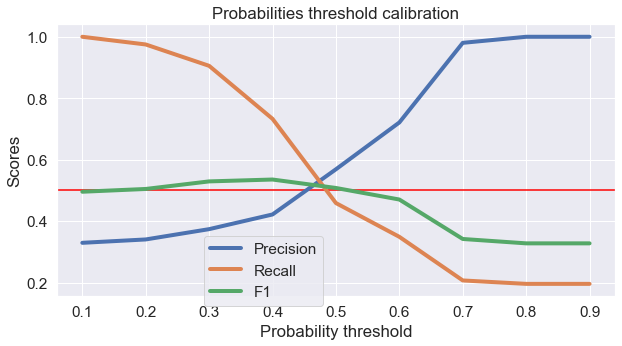

In [399]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
         
    figure = plt.figure(figsize = (10, 5))

    plt1 = figure.add_subplot(111)
    plt1.axhline(0.5, color="red")
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25));
    
y_valid_proba = final_model.predict_proba(X_valid)[:, 1]
show_proba_calibration_plots(y_valid_proba, y_valid)

In [404]:
y_valid_pred = np.array(y_valid_proba > 0.475, dtype=int)
get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.83      0.88      0.85      3631
           1       0.62      0.52      0.57      1394

    accuracy                           0.78      5025
   macro avg       0.73      0.70      0.71      5025
weighted avg       0.77      0.78      0.77      5025

VALID

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1756
           1       0.53      0.53      0.53       719

    accuracy                           0.73      2475
   macro avg       0.67      0.67      0.67      2475
weighted avg       0.73      0.73      0.73      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1419  337
1                339  380


## Прогнозирование на тестовом датасете и сохранение финальной модели

In [405]:
test_df.shape

(2500, 20)

In [406]:
predict_proba = final_model.predict_proba(test_df)[:, 1]
predict_proba

array([0.48163234, 0.31663287, 0.98582664, ..., 0.40885067, 0.3382235 ,
       0.98905642])

In [411]:
len(predict_proba)

2500

In [412]:
predictions = np.array(predict_proba > 0.47, dtype=int)
predictions

array([1, 0, 1, ..., 0, 0, 1])

In [413]:
pd.DataFrame(predictions).to_csv('NMakarevich_predictions2.csv', header=None, index=None)